Ep 1/20, Score: 34.0, ε: 0.97
Ep 2/20, Score: 46.0, ε: 0.94
Ep 3/20, Score: 24.0, ε: 0.91
Ep 4/20, Score: 23.0, ε: 0.89
Ep 5/20, Score: 20.0, ε: 0.86
Ep 6/20, Score: 29.0, ε: 0.83
Ep 7/20, Score: 21.0, ε: 0.81
Ep 8/20, Score: 11.0, ε: 0.78
Ep 9/20, Score: 13.0, ε: 0.76
Ep 10/20, Score: 25.0, ε: 0.74
Ep 11/20, Score: 12.0, ε: 0.72
Ep 12/20, Score: 23.0, ε: 0.69
Ep 13/20, Score: 14.0, ε: 0.67
Ep 14/20, Score: 22.0, ε: 0.65
Ep 15/20, Score: 22.0, ε: 0.63
Ep 16/20, Score: 17.0, ε: 0.61
Ep 17/20, Score: 16.0, ε: 0.60
Ep 18/20, Score: 18.0, ε: 0.58
Ep 19/20, Score: 16.0, ε: 0.56
Ep 20/20, Score: 17.0, ε: 0.54


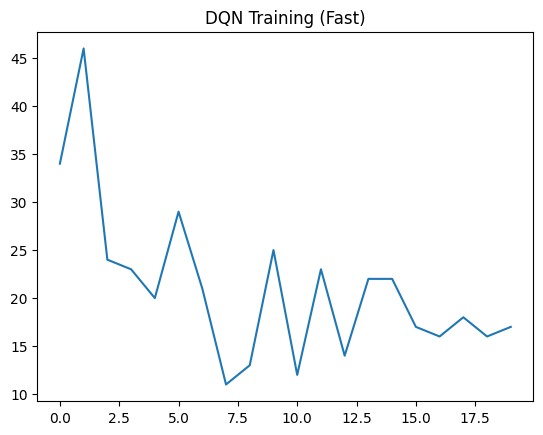

In [4]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

# Hyperparameters (optimized for speed)
EPISODES = 20
BATCH_SIZE = 32
GAMMA = 0.95
LEARNING_RATE = 0.001
MEMORY_SIZE = 1000
EPSILON_DECAY = 0.97

# Environment setup
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Simplified network
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, 16),
            nn.ReLU(),
            nn.Linear(16, action_size)
        )
    def forward(self, x):
        return self.net(x)

# Initialize components
policy_net = DQN()
target_net = DQN()
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
memory = deque(maxlen=MEMORY_SIZE)
epsilon = 1.0

def train():
    if len(memory) < BATCH_SIZE:
        return

    # Sample batch and fix dimensions
    batch = random.sample(memory, BATCH_SIZE)
    states = torch.FloatTensor(np.array([t[0] for t in batch]))  # Shape: [BATCH, state_size]
    actions = torch.LongTensor([t[1] for t in batch])
    rewards = torch.FloatTensor([t[2] for t in batch])
    next_states = torch.FloatTensor(np.array([t[3] for t in batch]))
    dones = torch.FloatTensor([t[4] for t in batch])

    # Q-value calculation
    current_q = policy_net(states).gather(1, actions.unsqueeze(-1))
    next_q = target_net(next_states).max(1)[0].detach()
    expected_q = rewards + (1 - dones) * GAMMA * next_q

    # Update model
    loss = nn.MSELoss()(current_q.squeeze(), expected_q)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Training loop
scores = []
for episode in range(EPISODES):
    state, _ = env.reset()
    score = 0

    for _ in range(200):  # Max steps
        # Epsilon-greedy action
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = policy_net(torch.FloatTensor(state)).argmax().item()

        # Environment step
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Store experience (flatten state)
        memory.append((state, action, reward, next_state, done))
        state = next_state
        score += reward

        # Train
        train()

        if done:
            break

    # Update parameters
    epsilon *= EPSILON_DECAY
    target_net.load_state_dict(policy_net.state_dict())

    scores.append(score)
    print(f"Ep {episode+1}/{EPISODES}, Score: {score}, ε: {epsilon:.2f}")

# Quick plot
plt.plot(scores)
plt.title('DQN Training (Fast)')
plt.show()